# Introduction to machine learning II: Titanic survival prediction challenge

Friday, September 27

In this second machine learning Notebook, we will apply several ML algorithms to tackle a popular data science challenge: ["Titanic: Machine Learning from Disaster"](https://www.kaggle.com/c/titanic/overview). This competition has been created by Kaggle, a community of data scientists, specialised in Machine Learning education (now owned by Google/Alphabet).
In this particular challenge, competitors are asked to predict the survivial probability of each passengers aboard the Titanic, given their biographic data.

We will also use it to review some of data handling methods we have covered earlier.


### Content

- [1. Statement of the problem](#1.-Statement-of-the-problem)
- [2. Prepare the tools](#2.-Prepare-the-tools)
- [3. Data preprocessing](#3.-Data-preprocessing)
- [4. Applying machine learning algorithms](#4.-Applying-machine-learning-algorithms)


### 1. Statement of the problem

#### 1.1. Historical background

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

#### 1.2. The statistical problem

In this Notebook we will apply several different machine learning algorithms to predict which passengers survived the tragedy.
We will use features on passenger's classes, names, gender, age, cabin, number of siblings/spouse aboard the ship, number of parents/children aboard the ship, ticket fare, port of embarkation. Based on these covariates, we will compare the different algorithms' performances.

### 2. Prepare the tools

#### 2.1. Step 1: import libraries

In [1]:
# Load packages
import sys                    # access to system parameters https://docs.python.org/3/library/sys.html
import pandas as pd 
import matplotlib
import numpy as np
import scipy as sp 
import IPython
from IPython import display   # pretty printing of dataframes in Jupyter notebook
import sklearn

# Other useful libraries
import random
import time

#### 2.2. Step 2: import machine learning-specific libraries

We will use the popular *scikit-learn* library to develop our machine learning algorithms. In *sklearn,* algorithms are called Estimators and implemented in their own classes. For data visualization, we will use the *matplotlib* and *seaborn* libraries **[TBC: we need an explanation of what seaborn is doing]**. Below are common classes to load.

In [2]:
# Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

# Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

# Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

#### 2.3. Step 3: Preview Data

In [18]:
# Import data from file GitHub
data_raw = pd.read_csv('https://raw.githubusercontent.com/arnauddyevre/titanic_data/master/train.csv')
data_val = pd.read_csv('https://raw.githubusercontent.com/arnauddyevre/titanic_data/master/test.csv')

# To play with our data, we'll create a copy
data1 = data_raw.copy(deep = True)

# We will use the following dataframe to clean both train and test datasets simultaneously
data_cleaner = [data1, data_val]

# Preview data
print (data_raw.info())
data_raw.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
646,647,0,3,"Cor, Mr. Liudevit",male,19.00,0,0,349231,7.8958,NaN,S
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,B58 B60,C
500,501,0,3,"Calic, Mr. Petar",male,17.00,0,0,315086,8.6625,NaN,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
239,240,0,2,"Hunt, Mr. George Henry",male,33.00,0,0,SCO/W 1585,12.2750,NaN,S
460,461,1,1,"Anderson, Mr. Harry",male,48.00,0,0,19952,26.5500,E12,S
63,64,0,3,"Skoog, Master. Harald",male,4.00,3,2,347088,27.9000,NaN,S
194,195,1,1,"Brown, Mrs. James Joseph (Margaret Tobin)",female,44.00,0,0,PC 17610,27.7208,B4,C
409,410,0,3,"Lefebre, Miss. Ida",female,NaN,3,1,4133,25.4667,NaN,S
459,460,0,3,"O'Connor, Mr. Maurice",male,NaN,0,0,371060,7.7500,NaN,Q


### 3. Data preprocessing

#### 3.1. The 4 C's of Data Cleaning: Correcting, Completing, Creating, and Converting**

At this stage, we will clean our data by 1) correcting aberrant values and outliers, 2) completing missing information, 3) creating new features for analysis, and 4) converting fields to the correct format for calculations and presentation.

1. **Correcting:** Reviewing the data, there does not appear to be any aberrant or non-acceptable data inputs. In addition, we see we may have potential outliers in age and fare. However, since they are reasonable values, we will wait until after we complete our exploratory analysis to determine if we should include or exclude from the dataset. It should be noted, that if they were unreasonable values, for example age = 800 instead of 80, then it's probably a safe decision to fix now. However, we want to use caution when we modify data from its original value, because it may be necessary to create an accurate model.
2. **Completing:** There are two common methods, either delete the record or populate the missing value using a reasonable input. It is not recommended to delete the record, especially a large percentage of records, unless it truly represents an incomplete record. Instead, it's best to impute missing values. A basic methodology for qualitative data is impute using mode. A basic methodology for quantitative data is impute using mean, median, or mean + randomized standard deviation.
3. **Creating:**  Feature engineering is when we use existing features to create new features to determine if they provide new signals to predict our outcome. For this dataset, we will create a title feature to determine if it played a role in survival.
4. **Converting:** Last, but certainly not least, we'll deal with formatting. There are no date or currency formats, but datatype formats. Our categorical data imported as objects, which makes it difficult for mathematical calculations. For this dataset, we will convert object datatypes to categorical dummy variables.

In [19]:
print('Train columns with null values:\n', data1.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', data_val.isnull().sum())
print("-"*10)

data_raw.describe(include = 'all')

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Flynn, Mr. John Irwin (""Irving"")",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


#### 3.2. Cleaning data

**COMPLETING**: complete or delete missing values in train and test/validation dataset

In [20]:
for dataset in data_cleaner:    
    # complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    # complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    # complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
#delete the cabin feature/column and others previously stated to exclude in train dataset
drop_column = ['PassengerId','Cabin', 'Ticket']
data1.drop(drop_column, axis=1, inplace = True)

print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


**CREATE**: Feature Engineering for train and test/validation dataset

In [21]:
for dataset in data_cleaner:    
    # Discrete variables
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

    # Quick and dirty code split title from name
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    # Continuous variable bins; qcut vs cut
    # Fare Bins/Buckets using qcut or frequency bins
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    # Age Bins/Buckets using cut or value bins
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

# Cleanup rare title names
# print(data1['Title'].value_counts())
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (data1['Title'].value_counts() < stat_min) #this will create a true false series with title name as index

# Apply and lambda functions are quick and dirty code to find and replace with fewer lines of code
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print("-"*10)

C:\Users\dyevre\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\dyevre\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------


preview data again

In [25]:
data1.info()
data_val.info()
data1.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 non-null category
AgeBin           891 non-null category
Sex_Code         891 non-null int32
Embarked_Code    891 non-null int32
Title_Code       891 non-null int32
AgeBin_Code      891 non-null int32
FareBin_Code     891 non-null int32
dtypes: category(2), float64(2), int32(5), int64(6), object(4)
memory usage: 102.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
Passe

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
152,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(48.0, 64.0]",1,2,3,3,1
49,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.0,1,0,17.8000,S,2,0,Mrs,"(14.454, 31.0]","(16.0, 32.0]",0,2,4,1,2
180,0,3,"Sage, Miss. Constance Gladys",female,28.0,8,2,69.5500,S,11,0,Miss,"(31.0, 512.329]","(16.0, 32.0]",0,2,2,1,3
38,0,3,"Vander Planke, Miss. Augusta Maria",female,18.0,2,0,18.0000,S,3,0,Miss,"(14.454, 31.0]","(16.0, 32.0]",0,2,2,1,2
149,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,13.0000,S,1,1,Misc,"(7.91, 14.454]","(32.0, 48.0]",1,2,1,2,1
385,0,2,"Davies, Mr. Charles Henry",male,18.0,0,0,73.5000,S,1,1,Mr,"(31.0, 512.329]","(16.0, 32.0]",1,2,3,1,3
613,0,3,"Horgan, Mr. John",male,28.0,0,0,7.7500,Q,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,1,3,1,0
673,1,2,"Wilhelms, Mr. Charles",male,31.0,0,0,13.0000,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]",1,2,3,1,1
763,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,120.0000,S,4,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,2,4,2,3
76,0,3,"Staneff, Mr. Ivan",male,28.0,0,0,7.8958,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,2,3,1,0


**CONVERT**: convert objects to category using Label Encoder for train and test/validation dataset **[here as well, more explanations about what is being done below would be useful]**

In [23]:
# Code categorical data
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

# Define y variable aka target/outcome
Target = ['Survived']

# Define x variables for original features aka feature selection
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')

# Define x variables for original w/bin features to remove continuous variables
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')

# Define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')

data1_dummy.head()


Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


Last check

In [24]:
print('Train columns with null values: \n', data1.isnull().sum())
print("-"*10)
print (data1.info())
print("-"*10)

print('Test/Validation columns with null values: \n', data_val.isnull().sum())
print("-"*10)
print (data_val.info())
print("-"*10)

data_raw.describe(include = 'all')

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 non-null catego

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Flynn, Mr. John Irwin (""Irving"")",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


#### 3.3. Split training and validation data

We will use *sklearn* function to split the training data in two datasets; 75/25 split. This is important, so we don't [overfit our model](https://www.coursera.org/learn/python-machine-learning/lecture/fVStr/overfitting-and-underfitting). **[I think it would be better if the explanation was written here, rather than referenced in a hyperlink. It's an imprtant decision and it seems a bit arbitrary at the moment]**

In [10]:
#split train and test data with function defaults
#random_state -> seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)


print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


### 4. Applying machine learning algorithms

**[I think this whole secton needs to be a bit more detailed. The code needs to be contextualised and I think students would appreciate a more progressive introduction to what we are doing here. For instance, what is the point of cross-validation? What are all these techniques about? (if we mention them, we should introduce them in greater detail: short description in words, formula, and advantages/disadvantages of the method)]**

We will use a classification algorithm from the *sklearn* library to begin our analysis. We will use cross validation and scoring metrics, discussed in later sections, to rank and compare our algorithms’ performance.

**Machine Learning Selection:*
* [Sklearn Estimator Overview](http://scikit-learn.org/stable/user_guide.html)
* [Sklearn Estimator Detail](http://scikit-learn.org/stable/modules/classes.html)
* [Choosing Estimator Mind Map](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
* [Choosing Estimator Cheat Sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf)

Now that we identified our solution as a supervised learning classification algorithm. We can narrow our list of choices.

**Machine Learning Classification Algorithms:**
* [Ensemble Methods](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Generalized Linear Models (GLM)](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)
* [Naive Bayes](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes)
* [Nearest Neighbors](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors)
* [Support Vector Machines (SVM)](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
* [Decision Trees](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree)
* [Discriminant Analysis](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.discriminant_analysis)


In [11]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    ]

In [12]:
#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv  = cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837266,0.826119,0.0453876,0.0526167
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895131,0.823507,0.0666115,0.0168145
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.866667,0.822761,0.0498731,0.0808086
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.835768,0.822761,0.0493681,0.0482544
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.890075,0.822388,0.0697631,0.0169207
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.822015,0.0539292,0.00533757
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.891011,0.819776,0.0699157,0.0269539
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.0690863,0.00221417
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.820412,0.81194,0.0498606,0.0829229
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.871723,0.810448,0.0492537,0.241416


Text(0, 0.5, 'Algorithm')

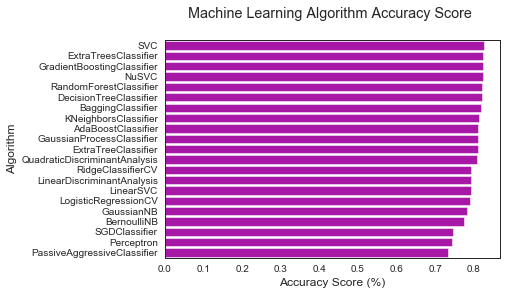

In [13]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')